In [1]:
# required for jupyter notebook
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(8,6)}) # set sns figure size

import os
import math

In [2]:
# read raw csv by marking dropping missing values
missing_values = ['NIL', 'nil', '']
raw_df = pd.read_csv(os.path.join('..', '..', 'Datasets', 'brri-datasets', 'all-station_raw.csv'), 
                     na_values=missing_values)

raw_df.sample(5)

,Station,Year,Month,Day,Max Temp. (degree Celcius),Min Temp. (degree Celcius),Rainfall (mm),Actual Evaporation (mm),"Relative Humidity (morning, %)","Relative Humidity (afternoon, %)",Sunshine (hour/day),Cloudy (hour/day),Solar Radiation (cal/cm^2/day)
3386,Rangpur,2018,3,17,31.2,17.2,0.0,3.0,53.0,50.0,0.0,11.8,162.20
459,Barisal,2018,4,13,30.0,21.5,NaN,4.0,90.0,88.0,9.4,3.2,481.25
1160,Barisal,2020,3,14,34.0,21.0,0.0,3.0,79.0,60.0,6.6,5.3,374.57
3435,Rangpur,2018,5,5,26.4,20.2,0.0,4.0,82.0,72.0,3.3,3.3,294.65
369,Barisal,2018,1,13,20.8,8.6,0.0,1.0,93.0,60.0,4.4,6.4,229.73


In [3]:
preProcessed_df = raw_df.copy()

## 1. Replace invalid values with NaN

- Max/Min Temp. (degree Celcius) > 50 
- Relative Humidity (afternoon, %) > 100, 
- Sunshine/Cloudy (hour/day) > 24, 
- Solar Radiation (cal/cm^2/day) > 1000 (from the box plot)

In [4]:
preProcessed_df.loc[preProcessed_df['Max Temp. (degree Celcius)'] > 50, 'Max Temp. (degree Celcius)'] = math.nan
preProcessed_df.loc[preProcessed_df['Min Temp. (degree Celcius)'] > 50, 'Min Temp. (degree Celcius)'] = math.nan
preProcessed_df.loc[preProcessed_df['Relative Humidity (afternoon, %)'] > 100, 'Relative Humidity (afternoon, %)'] = math.nan
preProcessed_df.loc[preProcessed_df['Sunshine (hour/day)'] > 24, 'Sunshine (hour/day)'] = math.nan
preProcessed_df.loc[preProcessed_df['Cloudy (hour/day)'] > 24, 'Cloudy (hour/day)'] = math.nan
preProcessed_df.loc[preProcessed_df['Solar Radiation (cal/cm^2/day)'] > 1000, 'Solar Radiation (cal/cm^2/day)'] = math.nan

In [5]:
# show_missing_data(preProcessed_df)

## 2. Fill up (or drop) the missing values

In [6]:
def show_missing_data(_df):
    df = _df.copy()
    total_cnt = df.shape[0]
    missing_cnt = df.shape[0]-df.dropna().shape[0]
    print(f'Total instances={total_cnt}, missing={missing_cnt}({round(missing_cnt*100.0/total_cnt, 2)}%)')

show_missing_data(preProcessed_df)

Total instances=4954, missing=880(17.76%)


**fillup with monthly average (of all years) for each station**

In [7]:
for column in preProcessed_df.columns:
    if column in ['Station', 'Year', 'Month', 'Day']:
        continue
        
    preProcessed_df[column] = preProcessed_df.groupby(['Station', 'Month'])[column].transform(
        lambda grp: grp.fillna(np.mean(grp))
    )
    
show_missing_data(preProcessed_df)

Total instances=4954, missing=210(4.24%)


In [8]:
# missing_df = preProcessed_df[(preProcessed_df['Station']=='Habiganj') & (preProcessed_df.isna().any(axis=1))]
# missing_df['Month'].value_counts()

In [9]:
# preProcessed_df[preProcessed_df['Station']=='Habiganj']['Month'].value_counts()

**Whole month data is missing (all years) for Habiganj, have to drop them**

In [10]:
preProcessed_df.dropna(inplace=True)
show_missing_data(preProcessed_df)

Total instances=4744, missing=0(0.0%)


In [11]:
preProcessed_df['Station'].value_counts()

Gazipur     1827
Barisal     1453
Rangpur     1127
Habiganj     337
Name: Station, dtype: int64

## 3. Drop unnecessary columns- 'Year', 'Day'

In [12]:
preProcessed_df.drop(columns=['Year', 'Day'], inplace=True)

## 4. Convert categorical column- 'Station' to numerical using One Hot Encoding

In [13]:
preProcessed_df = pd.get_dummies(preProcessed_df, columns=['Station'])
preProcessed_df.sample(5)

,Month,Max Temp. (degree Celcius),Min Temp. (degree Celcius),Rainfall (mm),Actual Evaporation (mm),"Relative Humidity (morning, %)","Relative Humidity (afternoon, %)",Sunshine (hour/day),Cloudy (hour/day),Solar Radiation (cal/cm^2/day),Station_Barisal,Station_Gazipur,Station_Habiganj,Station_Rangpur
939,8,31.6,27.6,4.000000,6.0,91.0,82.0,9.7,3.1,503.06,1,0,0,0
689,11,29.6,16.8,1.107494,1.0,94.0,46.0,6.9,4.1,303.39,1,0,0,0
2384,7,36.7,26.4,0.000000,5.0,87.0,65.0,6.2,7.3,386.99,0,1,0,0
193,7,27.0,26.2,8.400000,1.4,96.0,96.0,0.0,13.4,187.60,1,0,0,0
81,3,32.8,18.0,0.000000,2.0,90.0,47.0,8.1,3.8,422.29,1,0,0,0


## Save the pre-processed dataset

In [14]:
preProcessed_df.to_csv(os.path.join('..', '..', 'Datasets', 'brri-datasets', 'pre-processed', 'brri-weather_preprocessed_regression.csv'), index=False)

## Form the classification dataset and save
- class0: 0
- class1: 0 to 20 
- class2: greather than 20

In [15]:
def rain_classifier(_df):
    """
    create a column 'Rainfall' with classification labels with margins,
        - rainfall==0 -> no rain -> 0
        - rainfall>0 && rainfal<=22 -> light to moderate rain -> 1
        - rainfall>22 -> heavy to very heavy rain -> 2
        
    and drop the 'Rainfall (mm)' regression column
    """
    
    df = _df.copy()
    
    rainfall_labels = []
    
    for rainfall in df['Rainfall (mm)']:
        if rainfall==0:
            rainfall_labels.append(0) # no rain
        elif rainfall>0 and rainfall<=22:
            rainfall_labels.append(1) # light to moderate
        elif rainfall>22:
            rainfall_labels.append(2) # heavy
        else:
            print(f'outside rainfall margins -> {rainfall}')
            
    # insert classification column
    df['Rainfall'] = rainfall_labels
    # drop regression column
    df.drop(columns=['Rainfall (mm)'], inplace=True)

    return df

In [16]:
preProcessed_classification_df = rain_classifier(preProcessed_df)
preProcessed_classification_df.sample(5)

,Month,Max Temp. (degree Celcius),Min Temp. (degree Celcius),Actual Evaporation (mm),"Relative Humidity (morning, %)","Relative Humidity (afternoon, %)",Sunshine (hour/day),Cloudy (hour/day),Solar Radiation (cal/cm^2/day),Station_Barisal,Station_Gazipur,Station_Habiganj,Station_Rangpur,Rainfall
3754,3,29.2,16.5,2.0,85.0,47.0,8.0,3.8,415.12,0,0,0,1,0
671,11,29.6,18.0,2.0,95.0,46.0,7.5,3.5,318.97,1,0,0,0,1
1223,5,35.2,26.8,4.0,92.0,69.0,9.4,3.8,492.76,1,0,0,0,0
966,9,32.2,26.6,4.0,91.0,76.0,9.4,2.8,450.75,1,0,0,0,0
133,5,35.8,26.2,3.0,92.0,57.0,8.9,4.3,476.48,1,0,0,0,0


In [17]:
preProcessed_classification_df.to_csv(os.path.join('..', '..', 'Datasets', 'brri-datasets', 'pre-processed', 'brri-weather_preprocessed_classification.csv'), index=False)

In [18]:
def show_corr_heatmap(df):
    # https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

    plt.figure(figsize=(20, 10))

    corr_matrix = df.corr()

    # mask to hide the upper triangle of the symmetric corr-matrix
    # mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

    heatmap = sns.heatmap(

        # correlation matrix
        corr_matrix,

        # mask the top triangle of the matrix
        # mask=mask,

        # two-contrast color, different color for + -
        cmap="PiYG",

        # color map range
        vmin=-1, vmax=1,

        # show corr values in the cells
        annot=True
    )

    # set a title
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=16);

    plt.show()

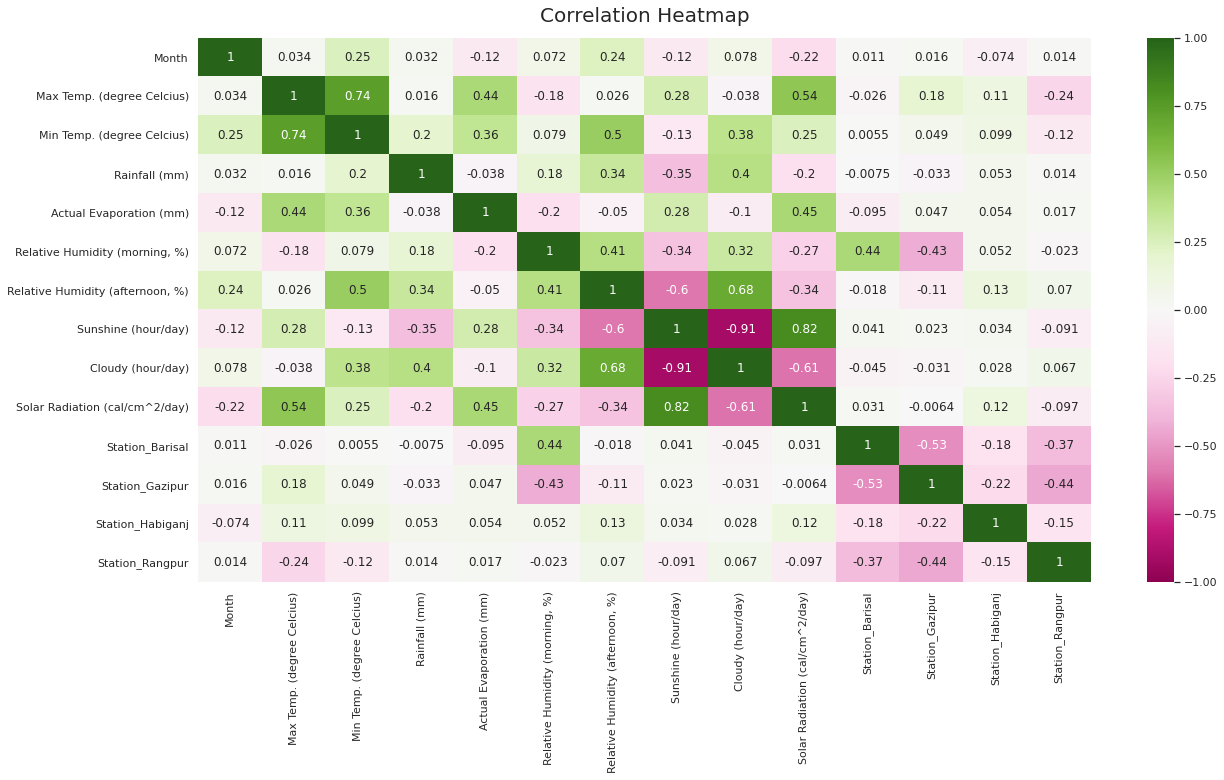

In [19]:
show_corr_heatmap(preProcessed_df)

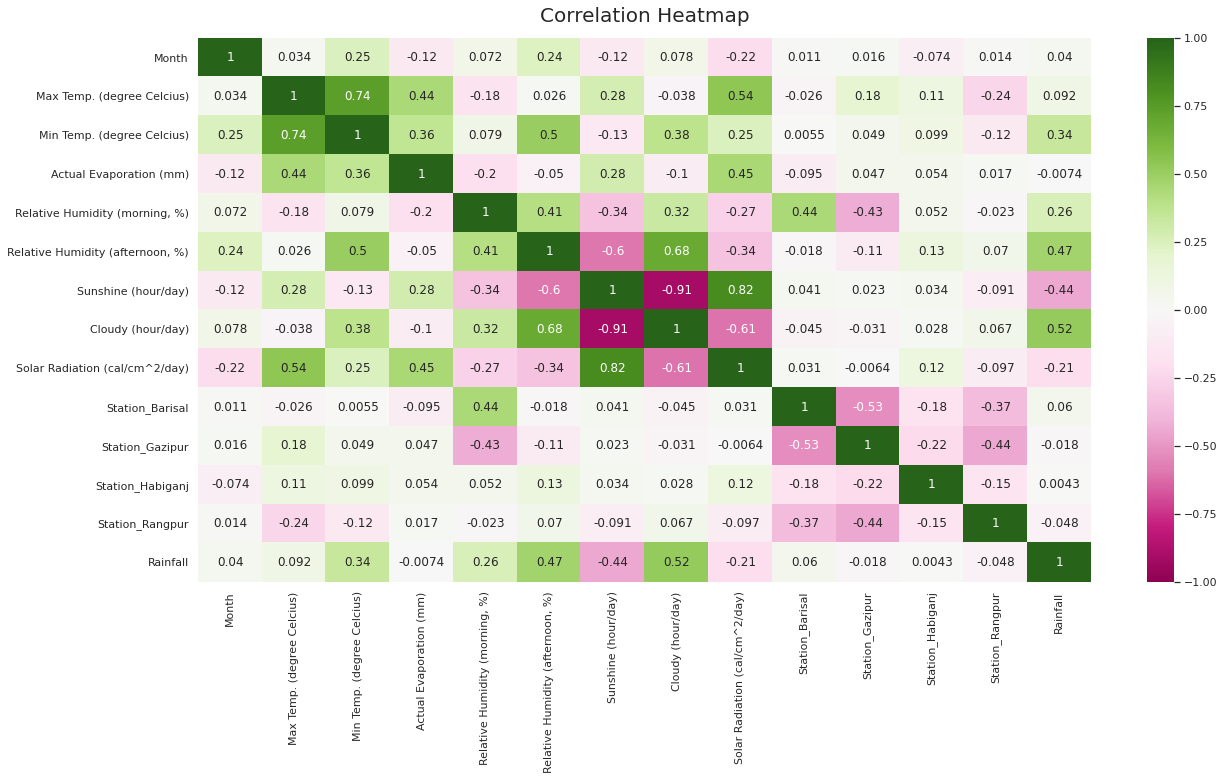

In [20]:
show_corr_heatmap(preProcessed_classification_df)

## Create separate train test datasets (ratio=80:20) and save

In [21]:
def splitTrainTest_and_scale(_df, class_label, is_regression=False):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import MinMaxScaler
    
    df = _df.copy()
    
    X_all = df.drop(columns=class_label)
    y_all = df[class_label]

    if(is_regression):
        X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42, shuffle=True)
    else:    
        X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42, shuffle=True, stratify=y_all)

    # scale the dataset
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    X_test_scaled = scaler.transform(X_test)
    X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)
    
    # concat X, y
    train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
    test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)
    
    return train_df, test_df

In [22]:
preProcessed_train_df, preProcessed_test_df = splitTrainTest_and_scale(preProcessed_df, \
                                                               class_label='Rainfall (mm)', \
                                                               is_regression=True)

preProcessed_classification_train_df, preProcessed_classification_test_df \
= splitTrainTest_and_scale(preProcessed_classification_df, class_label='Rainfall')

In [23]:
preProcessed_train_df.to_csv(os.path.join('..', '..', 'Datasets', 'brri-datasets', 'final-dataset', 'train', 'brri-weather_train_regression.csv'), index=False)
preProcessed_classification_train_df.to_csv(os.path.join('..', '..', 'Datasets', 'brri-datasets', 'final-dataset', 'train', 'brri-weather_train_classification.csv'), index=False)

preProcessed_test_df.to_csv(os.path.join('..', '..', 'Datasets', 'brri-datasets', 'final-dataset', 'test', 'brri-weather_test_regression.csv'), index=False)
preProcessed_classification_test_df.to_csv(os.path.join('..', '..', 'Datasets', 'brri-datasets', 'final-dataset', 'test', 'brri-weather_test_classification.csv'), index=False)